<span style="color:Green; font-family:Papyrus; font-size:2em;">Data Analysis</span>

We are going to provide data analysis based on each column, and also based on the relationships between various columns, with a special attention to the rating aspect in these relationships.

<span style="color:red; font-family:Papyrus; font-size:1.5em;">Importing Libraries</span>


In [1]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud, STOPWORDS
from pywaffle import Waffle
import os, io, folium, branca
import matplotlib.pyplot as plt
import folium.plugins as plugins
import bar_chart_race as bcr
from utils import *
# from IPython.display import display
import warnings, random
warnings.filterwarnings('ignore')

<span style="color:red; font-family:Papyrus; font-size:1.5em;">Reading the Data</span>


We import the data processed and cleaned in the *DataCleaningFeatEng.ipynb* notebook. The data set is made of 31 columns and 11115 rows. Also, there are no nan values, but we are going to choose our columns for data analysis.


In [2]:
df = pd.read_csv("data/df_ml_ds_final1.csv") 
da_columns = ["title", "authors", "average_rating", "num_pages", "ratings_count", "text_reviews_count", "genre_category", "publication_date", "publisher", "language_code", "publisher_country", "latitude", "longitude", "coordinates", "num_contributors", "size_of_publisher", "is_serie", "size_of_author", "book_count", "has_edition", "book_age"]
df_da= df[da_columns]
display(df_da.head(5))

,title,authors,average_rating,num_pages,ratings_count,text_reviews_count,genre_category,publication_date,publisher,language_code,...,latitude,longitude,coordinates,num_contributors,size_of_publisher,is_serie,size_of_author,book_count,has_edition,book_age
0,harry potter and the halfblood prince harry po...,j.k. rowling/mary grandpré,4.57,652,2095690,27591,fiction,9/16/2006,scholastic,eng,...,37.090240,-95.712891,"(37.09024, -95.712891)",2,3,1,2,2,1,1
1,harry potter and the order of the phoenix harr...,j.k. rowling/mary grandpré,4.49,870,2153167,29221,bildungsromans,9/1/2004,scholastic,eng,...,37.090240,-95.712891,"(37.09024, -95.712891)",2,3,1,2,1,1,1
2,harry potter and the chamber of secrets harry ...,j.k. rowling,4.42,352,6333,244,juvenile fiction,11/1/2003,scholastic,eng,...,37.090240,-95.712891,"(37.09024, -95.712891)",1,3,1,2,2,1,1
3,harry potter and the prisoner of azkaban harry...,j.k. rowling/mary grandpré,4.56,435,2339585,36325,juvenile fiction,5/1/2004,scholastic,eng,...,55.378051,-3.435973,"(55.378051, -3.435973)",2,3,1,2,2,1,1
4,harry potter boxed set books 15 harry potter 15,j.k. rowling/mary grandpré,4.78,2690,41428,164,biography & autobiography,9/13/2004,scholastic,eng,...,55.378051,-3.435973,"(55.378051, -3.435973)",2,3,1,2,1,0,1


<span style="color:red; font-family:Papyrus; font-size:1.5em;">General Overview</span>


In [3]:
# display(df_da.info())
display(df_da.isna().sum())
# display(df_da.describe())

title                 0
authors               0
average_rating        0
num_pages             0
ratings_count         0
text_reviews_count    0
genre_category        0
publication_date      0
publisher             0
language_code         0
publisher_country     0
latitude              0
longitude             0
coordinates           0
num_contributors      0
size_of_publisher     0
is_serie              0
size_of_author        0
book_count            0
has_edition           0
book_age              0
dtype: int64

<span style="color:blue; font-family:Papyrus; font-size:1.5em;">Correlation Matrix</span>

First we begin by the correlation matrix in order to spot interesting correlations among the data. We found out several high correlations, the threshold we set is 0.5.
We found a very high correlation between text_review_count and ratings_count,a dn between book_count and has_edition. But we didn't find any interesting correlation between the average_rating and other attributes, except for the num_pages, which is slightly correlated with average rating with a correlation of 0.11. We also specified Spearman correlation, as it suits ordinal data more.

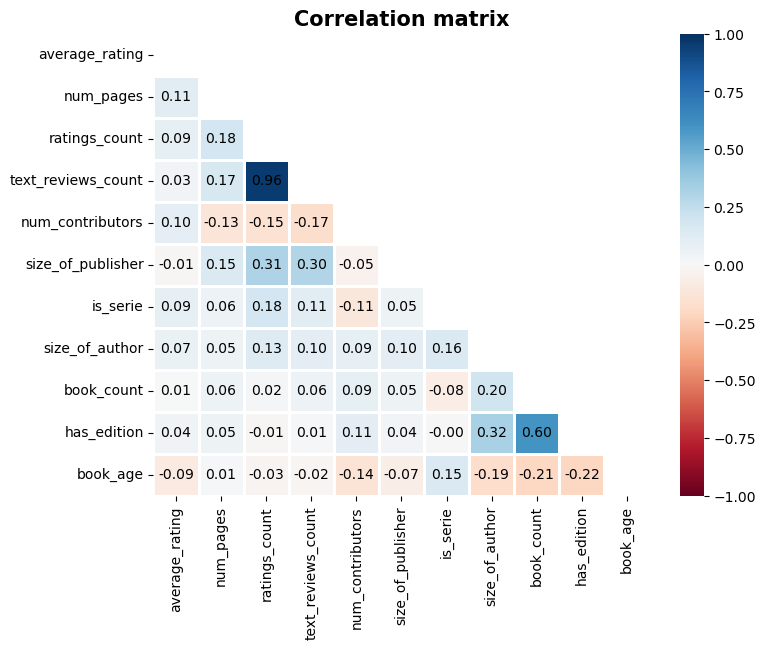

In [4]:
# Creation of a correlation matrix, to see the link between average_rating and all the numerical columns
df_cor = df_da[df_da.columns[~df_da.columns.isin(["latitude", "longitude"])]]
numeric_columns = df_cor.select_dtypes(include=['number']) 
matrix = numeric_columns.corr(method = "spearman") 

# Create a mask to hide the upper triangle 
mask = np.triu(np.ones_like(matrix, dtype=bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(8, 6))

# Create the heatmap without annotations
sns.heatmap(matrix, mask=mask, center=0, cmap='RdBu', linewidths=1, annot=False, vmin=-1, vmax=1, ax=ax)

# Manually annotate the heatmap
for i in range(len(matrix)):
    for j in range(len(matrix)):
        if mask[i, j] == False:
            ax.text(j + 0.5, i + 0.5, f"{matrix.iloc[i, j]:.2f}", ha='center', va='center', color='black', fontsize=10)
            
plt.title('Correlation matrix', fontsize=15, fontweight='bold')
plt.show()

<span style="color:blue; font-family:Papyrus; font-size:1.5em;">Analysing Different Features and Attributes</span>


<span style="color:red; font-family:Papyrus; font-size:1.5em;">title</span>

We want to see the most common words repeated in books' titles.

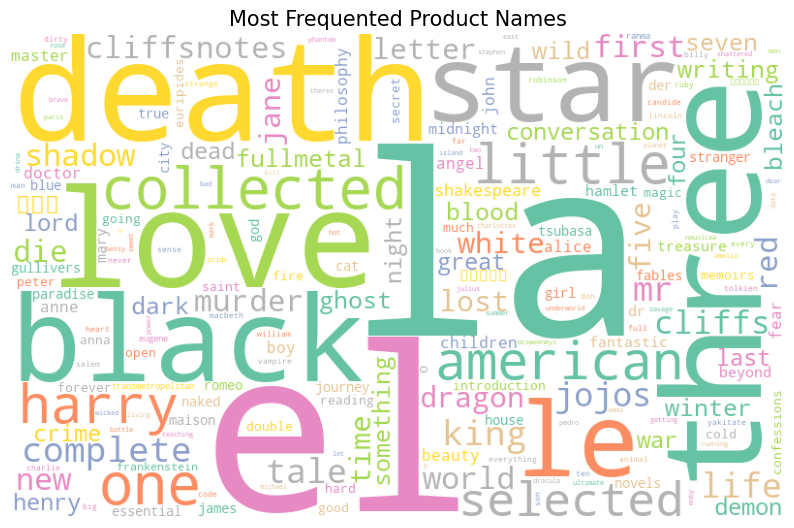

In [5]:
def plot_cloud(wordcloud):
    plt.figure(figsize=(10, 10))  
    plt.imshow(wordcloud)
    plt.title("Most Frequented Product Names", fontsize=15)
    plt.axis("off");
    
text = " ".join(cat.split()[0] for cat in df_da["title"])
wordcloud = WordCloud(width = 800, height = 500, random_state=1, background_color="white", colormap="Set2",
                      collocations=False, stopwords = STOPWORDS).generate(text)
plot_cloud(wordcloud)

In [6]:
#top 10 books with highest ratings
def rate2(row):
    if row["average_rating"] == 5.0:
        return "Max"
    elif 4.7 <= row["average_rating"] <= 4.9:
        return "Highest"
    elif 4.5 <= row["average_rating"] < 4.7:
        return "High"
    else:
        return "Low"
books = df_da[["title", "ratings_count", "average_rating"]].groupby(["title"]).agg({"ratings_count" : "sum", "average_rating": "mean"}).reset_index().sort_values("average_rating", ascending = False)
books["Rating_Category"] = books.apply(rate2, axis=1)
books = books.head(30)
fig3 = px.bar(books, y='ratings_count', x='title', color="Rating_Category", text_auto='.2s', title="Rating Count Vs. top 30 rated books")
fig3.update_xaxes(nticks=38)
fig3.update_traces(textfont_size=12, textangle=0, textposition="outside", marker_color='green', cliponaxis=False)
fig3.update_layout(xaxis={'categoryorder':'total descending'})
fig3.show()

Among the top 30 rated books, those with max rating (5.0) had the fewest rating counts. Those with the highest received the largest number of counts.

Investigating the titles to identify any repeated occurrences

In [7]:
# Check if the titles have dupliactes 
# first clean the title column - remove all punctuations and convert to lower case
df_da['clean_title'] = df_da['title'].str.replace('[^\w\s\d]', '', regex=True) # remove all punctuations - keeps numbers, letters and spaces in text
df_da['clean_title'] = df_da['title'].str.lower() # convert to lower case
# df['clean_title']
# # Check for duplicates in a specific column using value_counts
duplicates_count = df_da['clean_title'].value_counts()
# duplicates_count
# # Display values with count greater than 1 (indicating duplicates)
print(duplicates_count[duplicates_count > 1])

clean_title
the iliad                                                        9
the brothers karamazov                                           9
anna karenina                                                    8
the odyssey                                                      8
gullivers travels                                                8
                                                                ..
harry potter and the chamber of secrets harry potter 2           2
harry potter and the prisoner of azkaban harry potter 3          2
the changeling                                                   2
phantoms                                                         2
montaillou cathars and catholics in a french village 12941324    2
Name: count, Length: 536, dtype: int64


According to the above data, there are 536 books that have duplicates. We can even notice that some of these books have the same title, but they differ in other features as publication date, authors, publishers, num_pages. However, what is interesting is that they all have the exact average_rating (i.e. books with same titles hold the same average_rating even if they differ in other features), which indicate that books belong to different editions. 

In [8]:
# Investigate more to make sure what is noticed previously is true
# df_da.query("clean_title == 'harry potter and the chamber of secrets (harry potter  #2)'")
# df_da.query("clean_title == 'harry potter and the prisoner of azkaban (harry potter  #3)'")
# df_da.query("clean_title == 'the iliad'")
df_da.query("clean_title == 'the brothers karamazov'")

,title,authors,average_rating,num_pages,ratings_count,text_reviews_count,genre_category,publication_date,publisher,language_code,...,longitude,coordinates,num_contributors,size_of_publisher,is_serie,size_of_author,book_count,has_edition,book_age,clean_title
1406,the brothers karamazov,fyodor dostoyevsky/constance garnett/manuel ko...,4.32,736,983,91,juvenile fiction,6/1/1999,signet,eng,...,-3.435973,"(55.378051, -3.435973)",4,3,0,3,9,1,0,the brothers karamazov
1407,the brothers karamazov,fyodor dostoyevsky/fyodor dostoevsky/richard p...,4.32,796,191531,6795,biography & autobiography,6/14/2002,farrar straus and giroux,eng,...,-3.435973,"(55.378051, -3.435973)",4,3,0,3,9,1,0,the brothers karamazov
1408,the brothers karamazov,fyodor dostoyevsky/david mcduff,4.32,1013,1673,184,fiction,2/27/2003,penguin,eng,...,-95.712891,"(37.09024, -95.712891)",2,3,0,3,9,1,0,the brothers karamazov
1409,the brothers karamazov,fyodor dostoyevsky/richard pevear/larissa volo...,4.32,796,617,80,fiction,9/3/1991,vintage usa,eng,...,-95.712891,"(37.09024, -95.712891)",3,1,0,3,9,1,0,the brothers karamazov
1410,the brothers karamazov,fyodor dostoyevsky/simon vance/thomas r. beyer...,4.32,16,20,2,fiction,5/1/2005,hovel audio,eng,...,-3.435973,"(55.378051, -3.435973)",3,1,0,3,9,1,0,the brothers karamazov
1411,the brothers karamazov,fyodor dostoyevsky/constance garnett/maire jaanus,4.32,720,1089,202,juvenile fiction,7/25/2004,barnes noble,eng,...,-95.712891,"(37.09024, -95.712891)",3,2,0,3,9,1,0,the brothers karamazov
1634,the brothers karamazov,fyodor dostoyevsky/richard pevear/larissa volo...,4.32,796,443,55,juvenile fiction,1/16/1992,vintage,eng,...,-3.435973,"(55.378051, -3.435973)",3,3,0,3,9,1,0,the brothers karamazov
1990,the brothers karamazov,fyodor dostoyevsky/andrew r. macandrew/konstan...,4.32,1072,1022,154,biography & autobiography,4/1/1984,bantam,eng,...,-3.435973,"(55.378051, -3.435973)",3,3,0,3,9,1,0,the brothers karamazov
9345,the brothers karamazov,fyodor dostoyevsky/thomas r. beyer jr./simon v...,4.32,16,3,1,juvenile fiction,5/1/2005,hovel audio,eng,...,-3.435973,"(55.378051, -3.435973)",3,1,0,3,9,1,0,the brothers karamazov


In [9]:
# Group by 'clean_title' and count the number of unique 'average_rating'
ratings_count_by_title = df_da.groupby('clean_title')['average_rating'].nunique() #nunique counts the number of unique elements
duplicates_count_by_title = ratings_count_by_title[ratings_count_by_title > 1] # get titles that have 2 or more different ratings
print(duplicates_count_by_title)

clean_title
1776                   2
a little princess      2
a matter of trust      2
alice in wonderland    2
before night falls     2
                      ..
the stranger           2
the tale of genji      2
trainspotting          2
v for vendetta         2
white fang             2
Name: average_rating, Length: 67, dtype: int64


In [10]:
# change the title name to look at different samples
df_da.query('clean_title == "a little princess"') # change the title name to look at different samples
duplicates_count_by_title.value_counts()

average_rating
2    61
3     3
4     2
6     1
Name: count, dtype: int64

<span style="color:red; font-family:Papyrus; font-size:1.5em;">is_serie</span>


We can see that the standalone books in the dataset are the majority.

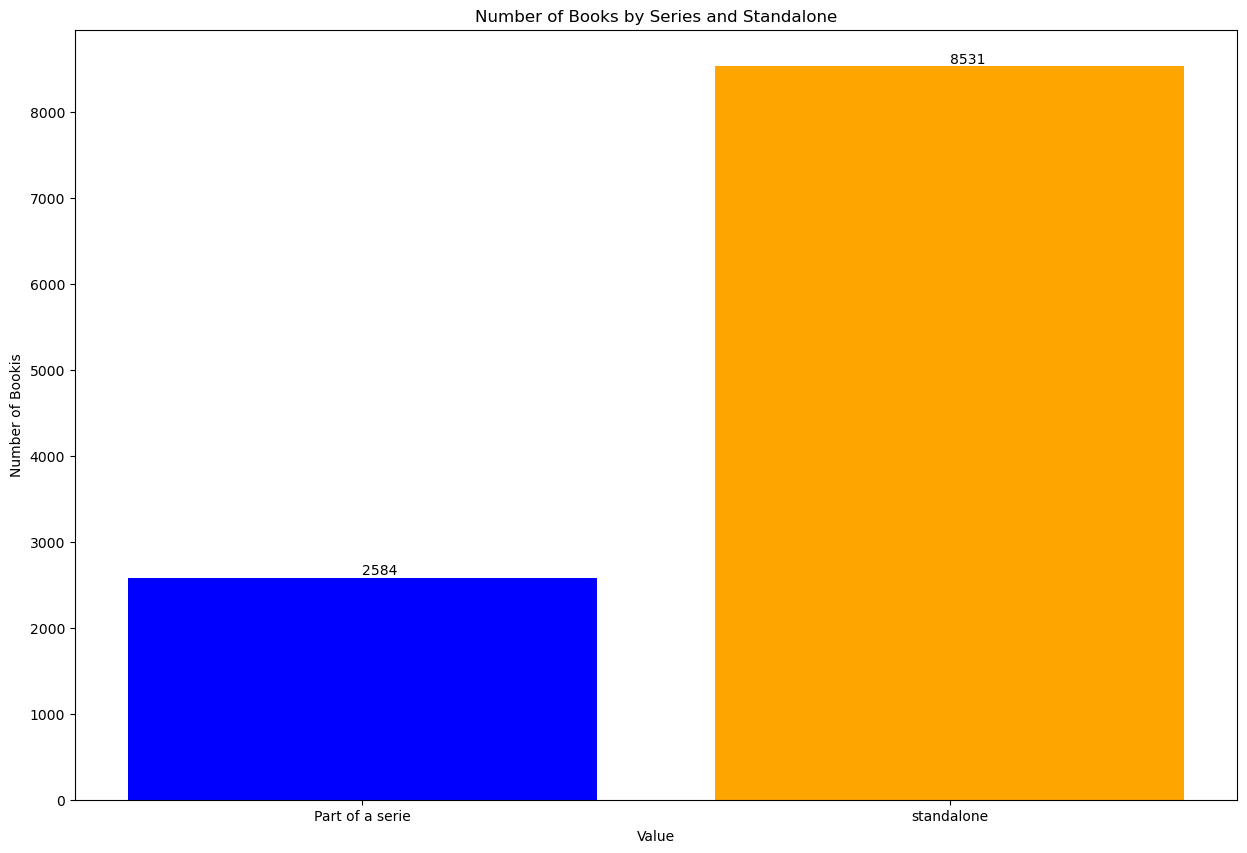

In [11]:
# Count the number of books with 1 and 0 in the 'is_serie' column
count_1 = df_da['is_serie'].sum()
count_0 = len(df_da) - count_1

# Plot the bar graph
plt.figure(figsize=(15,10))
# Create a bar plot
bars = plt.bar(['Part of a serie', 'standalone'], [count_1, count_0], color=['blue', 'orange'])

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Number of Bookis')
plt.title('Number of Books by Series and Standalone')

# Add values on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval}', va='bottom')

# Show the plot
plt.show()

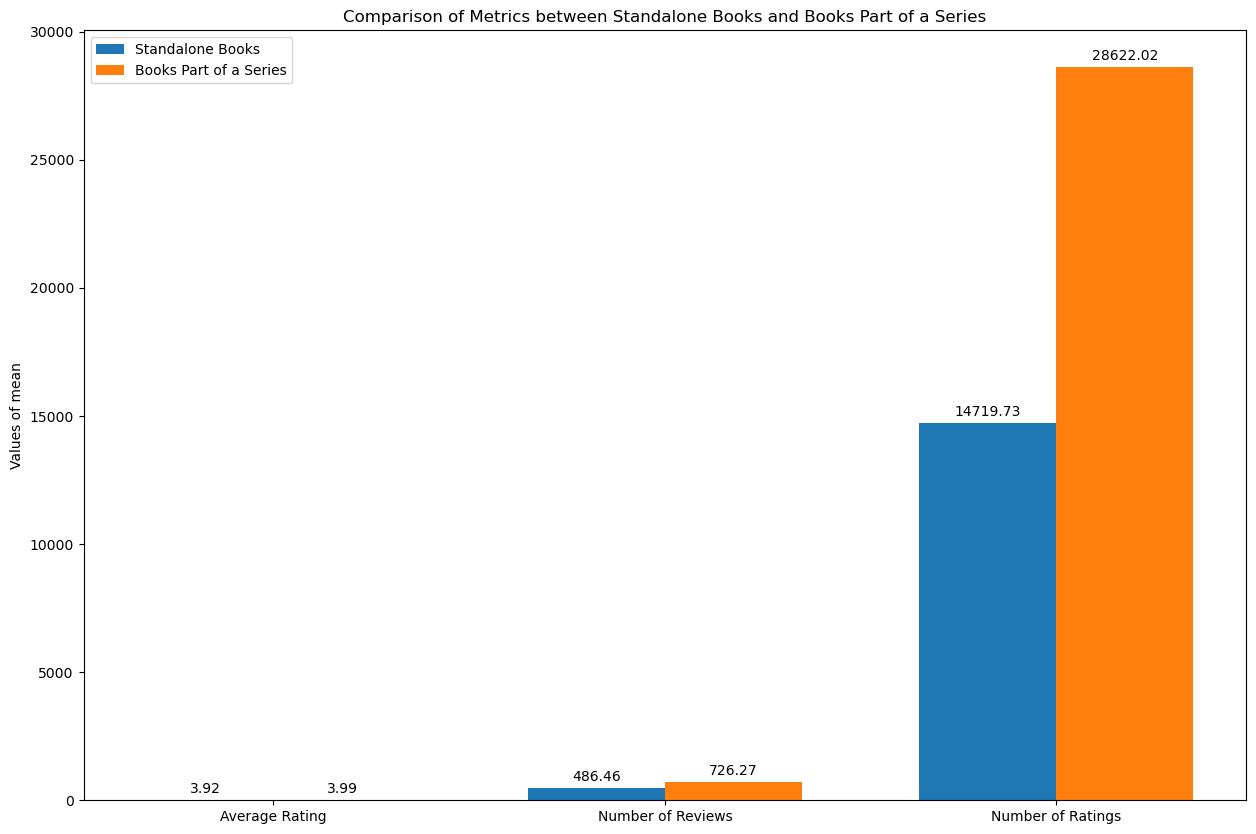

In [12]:
standalone_books = df_da[df_da['is_serie'] == 0]
series_books = df_da[df_da['is_serie'] == 1]

# Calculate the mean values for each metric for standalone books and books part of a series
avg_rating_standalone = standalone_books['average_rating'].mean()
avg_rating_series = series_books['average_rating'].mean()

num_reviews_standalone = standalone_books['text_reviews_count'].mean()
num_reviews_series = series_books['text_reviews_count'].mean()

num_ratings_standalone = standalone_books['ratings_count'].mean()
num_ratings_series = series_books['ratings_count'].mean()

# Plot the bar chart
categories = ['Average Rating', 'Number of Reviews', 'Number of Ratings']
standalone_values = [avg_rating_standalone, num_reviews_standalone, num_ratings_standalone]
series_values = [avg_rating_series, num_reviews_series, num_ratings_series]

x = range(len(categories))
width = 0.35

# Set the size of the figure
fig, ax = plt.subplots(figsize=(15, 10))

rects1 = ax.bar(x, standalone_values, width, label='Standalone Books')
rects2 = ax.bar([p + width for p in x], series_values, width, label='Books Part of a Series')

ax.set_ylabel('Values of mean')
ax.set_title('Comparison of Metrics between Standalone Books and Books Part of a Series')
ax.set_xticks([p + width / 2 for p in x])
ax.set_xticklabels(categories)
ax.legend()

# Add values on top of each bar
for rect in rects1:
    height = rect.get_height()
    ax.annotate('{:.2f}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

for rect in rects2:
    height = rect.get_height()
    ax.annotate('{:.2f}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

plt.show()

There is not a big impact on the average rating, but we see that books part of a serie have more ratings and more reviews.

<span style="color:red; font-family:Papyrus; font-size:1.5em;">average_rating (the target)</span>


A histogram is used to see how the data is distributed. The result is that we mostly have ratings between 3.5 and 4.5.

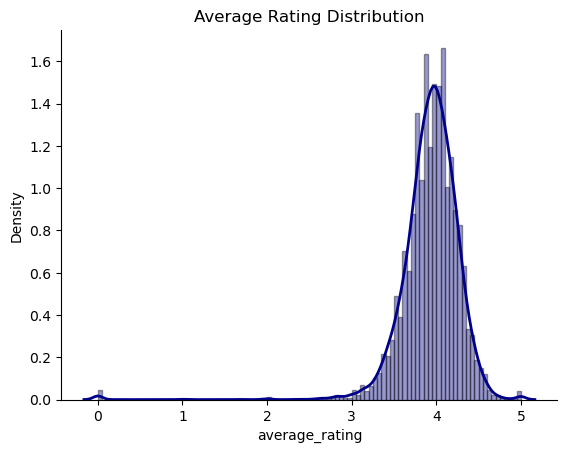

In [13]:
sns.distplot(df_da['average_rating'], hist=True, kde=True, 
             bins=100, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2}).set_title('Average Rating Distribution')

# Remove the top and right edges
sns.despine(right=True, top=True)
# Show the plot
plt.show()

In order to get a closer look into the average rating, we use pd.cut and value_counts to group the ratings into categories

In [14]:
# Define bins and labels
bins = [0, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
labels = ['0-1', '1-1.5', '1.5-2', '2-2.5', '2.5-3', '3-3.5', '3.5-4', '4-4.5', '4.5-5']

# Create a new column with the bin labels
rating_category = pd.cut(df_da['average_rating'], bins=bins, labels=labels, right=False)

# Count the number of ratings in each category
rating_counts_per_category = rating_category.value_counts()

# Display the result
res = pd.DataFrame({'average_rating_group':rating_counts_per_category.index, 'Count':rating_counts_per_category.values})
fig2 = px.bar(res, y='Count', x='average_rating_group', text_auto='.2s',
            title="Average rating group Distribution")
fig2

We can indeed see that average rating groups 3.5-4 and 4-4.5 are the most occuring ones.

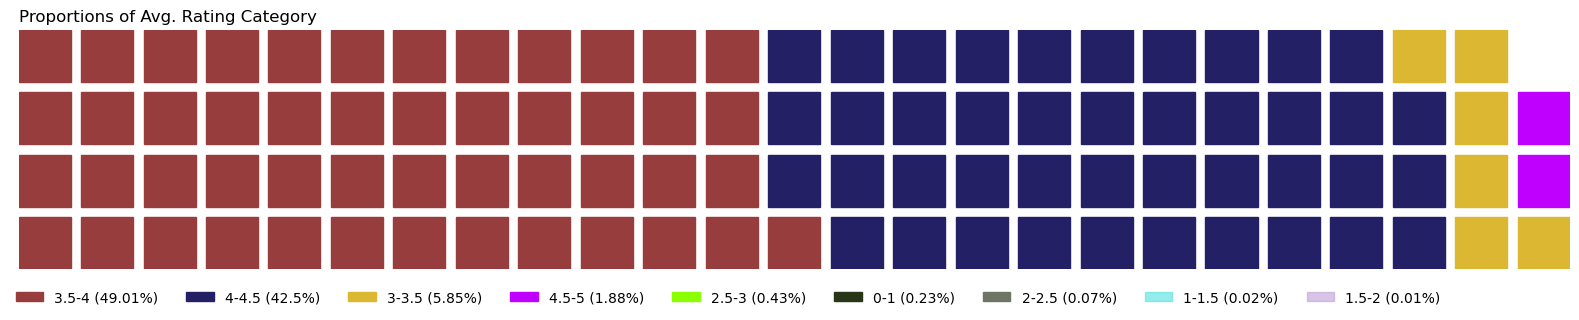

In [15]:
# Calculate the percentage of ratings between 3.5 and 4, and between 3.5 and 4.5 :
res = pd.DataFrame({'average_rating_group':rating_counts_per_category.index, 'Count':rating_counts_per_category.values})
total = sum(res["Count"])
proportions = [round((float(value) / total)*100, 2) for value in res["Count"]]# % of category sales each
res["Proportions"] = proportions
res = res.set_index("average_rating_group")
# res = res.drop(["Count"], axis = 1)
res = res["Proportions"].to_dict()
fig = plt.figure(FigureClass=Waffle, rows=4, values=res, figsize=(17, 20), 
    colors=("#983D3D", "#232066", "#DCB732", "#BF00FF", "#8aff00", "#283617", "#6e7565", "#5ce3e3a6", "#c2a5d9a6"),
    title={"label": "Proportions of Avg. Rating Category", "loc": "left"},
    labels=["{0} ({1}%)".format(k, v) for k, v in res.items()],
    legend={"loc": "lower left", "bbox_to_anchor": (-0.01, -0.2), "ncol": len(res), "framealpha": 0})
plt.show()

In terms of percentage, the two previous avg. rating groups account for 91% of the avg. ratings.

<span style="color:red; font-family:Papyrus; font-size:1.5em;">rating counts & text_review_count</span>


<span style="color:grey; font-family:Papyrus; font-size:1.5em;">rating counts</span>


In [16]:
fig = px.histogram(df_da, x="ratings_count", title="Rating Count Distribution")
fig.update_xaxes(nticks=30)
fig.show()

By inspecting the graph, we can see that ratings less than 50000 are the most dominant. 

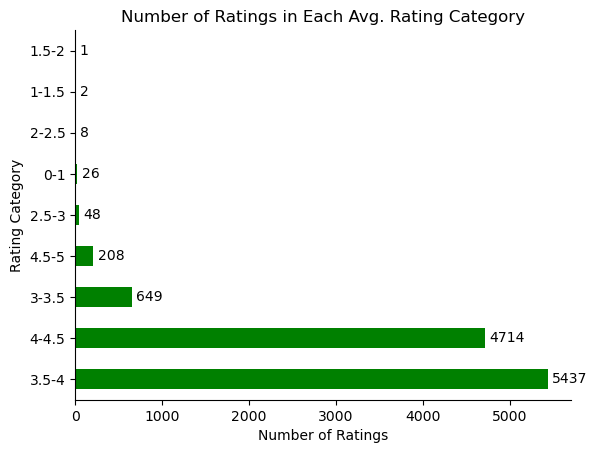

In [17]:
# Plot the total number of ratings belonging to each category 
# Plot the bar graph with different colors for each bar

# Plot the bar graph
ax = rating_counts_per_category.plot(kind='barh', color='green')

# Remove upper and left spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add labels and title
plt.ylabel('Rating Category')
plt.xlabel('Number of Ratings')
plt.title('Number of Ratings in Each Avg. Rating Category')

# Display values next to each bar
for index, value in enumerate(rating_counts_per_category):
    plt.text(value + 50, index, str(value), ha='left', va='center')

# Show the plot
plt.show()

We see here again also that larger ratings counts belong to the books with 3.5-4 and 4-4.5 avr. ratings groups.

In [18]:
fig6 = go.Figure()
fig6.add_trace(go.Box(
    y=df_da['ratings_count'],
    name='',
    marker_color='darkblue',
    boxmean=True # represent mean
))
fig6.update_layout(yaxis_range=[0,100000], title = "Boxplot for ratings_count")
fig6.show()

We also see from the boxplot that the majority of books don't have large rating counts, in comparison to the extreme rating counts for some books, thus, extreme values evidently influence the mean of 17 951 (can be read while hovering over the graph)

<span style="color:grey; font-family:Papyrus; font-size:1.5em;">text_review_count</span>


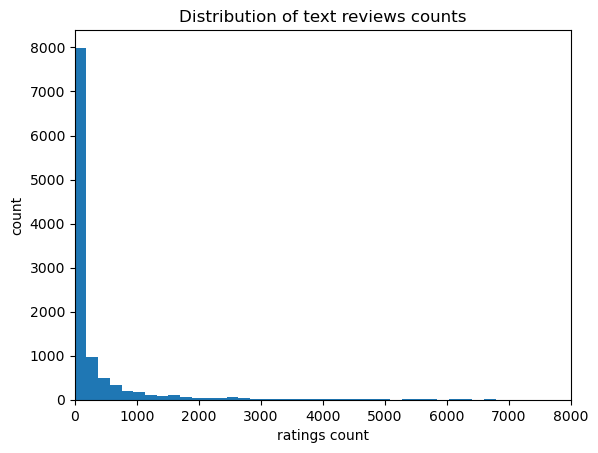

In [19]:
plt.hist(df['text_reviews_count'],bins=500)
plt.xlabel('ratings count')
plt.xlim(0,8000)
plt.ylabel('count')
plt.title('Distribution of text reviews counts')
plt.show()

We see that most text review count per book are the ones below 500, roughly speaking.

In [20]:
fig5 = px.scatter(df_da, x="text_reviews_count", y="average_rating")
fig5.show()
#The vast majority of books don't have a lot of ratings or text reviews but there is some high extremes that influences the mean.
# df_da.nlargest(10, 'text_reviews_count') #Lets look at the higher number of text review
# df_da.nlargest(10, 'ratings_count') #Lest look at the higher number of text review
print('The correlation between ratings_count and text_reviews_count is',df['ratings_count'].corr(df['text_reviews_count'], method="spearman"))
print('The correlation between average_rating and text_reviews_count is',df['average_rating'].corr(df['text_reviews_count'], method="spearman"))

The correlation between ratings_count and text_reviews_count is 0.9586340805021224
The correlation between average_rating and text_reviews_count is 0.03329558242922451


It proves difficult to articulate some type of relationship just by reading the graph, that s why calculating the correlation of 0.03 proves this difficulty.

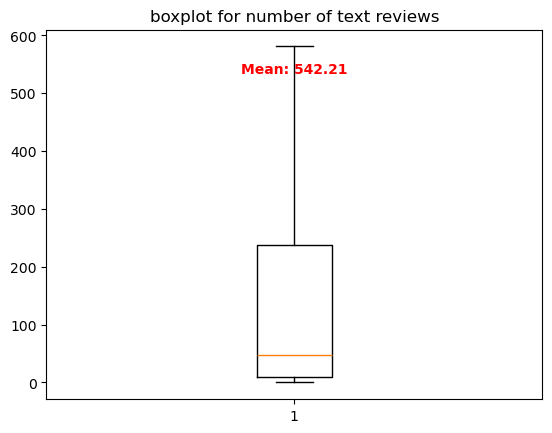

In [21]:
plt.boxplot(df_da['text_reviews_count'], 0, '')
plt.title('boxplot for number of text reviews')
mean_value = df_da['text_reviews_count'].mean()
plt.text(1, mean_value, f'Mean: {mean_value:.2f}', ha='center', va='center', color='red', fontweight='bold')
plt.show()

We also see from the boxplot that the majority of books don't have large text review counts, in comparison to the extreme rating counts for some books, thus, extreme values evidently influence the mean of 542.

<span style="color:red; font-family:Papyrus; font-size:1.5em;">Genre</span>


Now, we check the relationship between genre and average ratings. The size of the box corresponds to ratings count, while the color corresponds to average rating. We see that the genre of bildungsromans is the one receiving higher ratings while at the same time receiving a relativley high rating count.

In [22]:
tree_data = df_da[["average_rating", "ratings_count", "genre_category"]]
tree_data['ratings_count'] = tree_data['ratings_count'].apply(lambda x: 0.1 if x == 0 else x)
fig10 = px.treemap(tree_data, path = ["genre_category"], values = "ratings_count", width = 800, height = 400, color = "average_rating",
                  color_continuous_scale='PuOr',
                  title = "Rating & Rating Count & Genre")
fig10.update_layout(margin = dict(t=25, l=0, r=0, b=0))
fig10.show()

In [23]:
g = pd.DataFrame(df_da['genre_category'].value_counts()).reset_index()
g = g.head(10)
fig3 = px.bar(g, y='count', x='genre_category', text_auto='.2s', title="Top 10 Occuring Genre")
fig3.update_xaxes(nticks=38)
fig3.update_traces(textfont_size=12, textangle=0, textposition="outside", marker_color='green', cliponaxis=False)
fig3.show()

<span style="color:red; font-family:Papyrus; font-size:1.5em;">Publisher Country</span>


In [24]:
countries = (pd.read_csv("data/countries.csv").rename(columns={"name":"publisher_country"}))
den_map = df_da[["publisher_country", "ratings_count"]].groupby(["publisher_country"]).agg({"ratings_count" : "mean"}).reset_index()
countries = to_lower(countries, ["publisher_country"])
den_map = pd.merge(den_map, countries, on = "publisher_country")
# den_map 
fig = px.density_mapbox(den_map, lat='latitude', lon='longitude', z='ratings_count', radius=40,
                        center=dict(lat=40.463667, lon=-3.749220), zoom=2,
                        mapbox_style='carto-positron',#'stamen-terrain'
                        opacity = 1, color_continuous_scale='inferno')
fig.add_trace(
    go.Scattermapbox(
        lat=den_map["latitude"],
        lon=den_map["longitude"],
        mode="markers",
        showlegend=False,
        hoverinfo="skip",
        marker={
            "color": den_map["ratings_count"],
            "size": den_map["ratings_count"],
            "coloraxis": "coloraxis",
            "sizeref": (den_map["ratings_count"].max()) / 30 ** 2,
            "sizemode": "area",
        },
    )
)
fig.update_layout(
        title_text = 'Rating Count Per Country')
fig.show()

We remark that the United States and United Kingdom are the ones whose books receive the highest rating count. This is based on the assumption we did in our scrapper that the english language books come either from the US or UK.

In [25]:
def str_to_tuple(row):
    coord = row["coordinates"]
    coord = coord.replace("(", "")
    coord = coord.replace(")", "")
    return tuple(map(float, coord.split(",")))

def rate(row):
    if row["average_rating"] > 4.5:
        return "Highest"
    elif 4.0 <= row["average_rating"] <= 4.5:
        return "High"
    elif 3.0 <= row["average_rating"] < 4.0:
        return "Low"
    else:
        return "Lowest"

df_da["Avg_Rating_Category"] = df_da.apply(rate, axis=1)
map_data = df_da[["publisher_country", "Avg_Rating_Category"]].groupby(["publisher_country", "Avg_Rating_Category"]).size().reset_index().rename({0:"N"}, axis = 1)
coordinates = df_da[["publisher_country", "coordinates"]]
map_data = pd.merge(map_data, coordinates, on=['publisher_country'])
map_data = map_data.pivot_table(index = ["publisher_country", "coordinates"], columns = "Avg_Rating_Category", values = "N", fill_value = 0).reset_index()
pie_data = zip(map_data.High, map_data.Highest, map_data.Low, map_data.Lowest)

fig = plt.figure(figsize=(0.5, 0.5))
fig.patch.set_alpha(0)
ax = fig.add_subplot(111)
plots = []
for sizes in pie_data:
    ax.pie(sizes, colors=("#808000", "#008000", "#800080", "#FFBF00"))
    buff = io.StringIO()
    plt.savefig(buff, format="SVG")
    buff.seek(0)
    svg = buff.read()
    svg = svg.replace("\n", "")
    plots.append(svg)
    plt.cla()
plt.clf()
plt.close()

#html for legend
legend_html = """
{% macro html(this, kwargs) %}
<div style="
    position: fixed;
    bottom: 50px;
    left: 50px;
    width: 250px;
    height: 115px;
    z-index:9999;
    font-size:14px;
    ">
    <p><a style="color:#008000;font-size:100%;margin-left:20px;">◼</a>&emsp;Highest</p>
    <p><a style="color:#808000;font-size:100%;margin-left:20px;">◼</a>&emsp;High</p>
    <p><a style="color:#800080;font-size:100%;margin-left:20px;">◼</a>&emsp;Low</p>
    <p><a style="color:#FFBF00;font-size:100%;margin-left:20px;">◼</a>&emsp;Lowest</p>
</div>
{% endmacro %}
"""

loc = 'Rating Categories Per Country'
title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format(loc)   

legend = branca.element.MacroElement()
legend._template = branca.element.Template(legend_html)
#-----------

m = folium.Map(location=(40.463667, -3.749220), zoom_start=4)
map_data["coordinates1"] = map_data[["coordinates"]].apply(str_to_tuple, axis=1)
for i, coord in enumerate(map_data.coordinates1):
    marker = folium.Marker(coord)
    icon = folium.DivIcon(html=plots[i])
    marker.add_child(icon)
    popup = folium.Popup(
        "Highest: {}<br>\nHigh: {}<br>\nLow: {}<br>\nLowest: {}".format(map_data.Highest[i], map_data.High[i], map_data.Low[i], map_data.Lowest[i])
    )
    marker.add_child(popup)
    m.add_child(marker)
m.get_root().add_child(legend)
m.get_root().html.add_child(folium.Element(title_html))
plugins.Geocoder().add_to(m)# adding search box
m

We remark here that according to the average rating category, four in our case, that Brazil, Egypt, Indonesia and Sweden all of their books receive an average rating of Low (violet). Croatia received only the Lowest (Yellow) average ratings. Other countries, it was mix of all categories or few of them.

In [26]:
dyn_data = df_da[["publication_date", "publisher_country"]].groupby(["publication_date", "publisher_country"]).size().reset_index().rename({0:"N"}, axis = 1)
dyn_data["publication_date"] = pd.to_datetime(dyn_data["publication_date"])
dyn_data = dyn_data.pivot_table(index = ["publication_date"], columns = "publisher_country", values = "N", fill_value = 0)#.reset_index().set_index("Customer ID")
for i in dyn_data.columns:
    dyn_data[i] = dyn_data[i].cumsum()

dyn_data = dyn_data.head(30)
# dyn_data
bcr.bar_chart_race(df=dyn_data, filename=None)
bcr.bar_chart_race(
    df=dyn_data,
    filename=None,
    orientation='h',
    sort='desc',
    n_bars=len(df_da["publisher_country"].unique().tolist()), #states
    fixed_order=False,
    fixed_max=True,
    steps_per_period=2,
    interpolate_period=False,
    label_bars=True,
    bar_size=.95,
    period_label={'x': .99, 'y': .25, 'ha': 'right', 'va': 'center', 'size': 10, 'family': 'Courier New'},
    period_fmt='%B %d, %Y',
    period_summary_func=lambda v, r: {'x': .99, 'y': .18,
                                      's': f'Total Productions: {v.nlargest(6).sum():,.0f}',
                                      'ha': 'right', 'size': 7, 'family': 'Courier New'},
    perpendicular_bar_func='median',
    period_length=1000,
    figsize=(5, 6),
    dpi=140,
    cmap='dark12',
    title='Evolution of Book Production Since 1900',
    title_size=8,
    bar_label_size=3,
    tick_label_size=5,
    shared_fontdict={'family' : 'Helvetica', 'color' : '.9'},
    scale='linear',
    writer=None,
    fig=None,
    bar_kwargs={'alpha': .4},
    filter_column_colors=False)

This is bar chart race traces back over time the total production of books of every country in the data set since the earliest recorded publication date in the data set.

<span style="color:red; font-family:Papyrus; font-size:1.5em;">Publisher</span>


In [27]:
# number of publishers 
number_of_publisher = df_da["publisher"].nunique()
print("Number of publisher :", number_of_publisher)

Number of publisher : 2039


In [28]:
#top 30 publishing house that has highest ratings
p = df_da[["publisher", "ratings_count", "average_rating"]].groupby(["publisher"]).agg({"ratings_count" : "sum", "average_rating": "mean"}).reset_index().sort_values("average_rating", ascending = False)
p = p.head(30)
p["Rating_Category"] = p.apply(rate2, axis=1)
fig = px.bar(p, y='ratings_count', x='publisher', color="Rating_Category", text_auto='.2s', title="Rating Count Vs. top 30 rated Publishers")
fig.update_xaxes(nticks=38)
fig.update_traces(textfont_size=12, textangle=0, textposition="outside", marker_color='green', cliponaxis=False)
fig.update_layout(xaxis={'categoryorder':'total descending'})
fig.show()

Interacting with the graph: We notice that, those publishers that had the max average rating of 5, have in fact low rating count. The same with those with low average rating. Only those with the high and mostly highest which received a paralell larger rating counts.

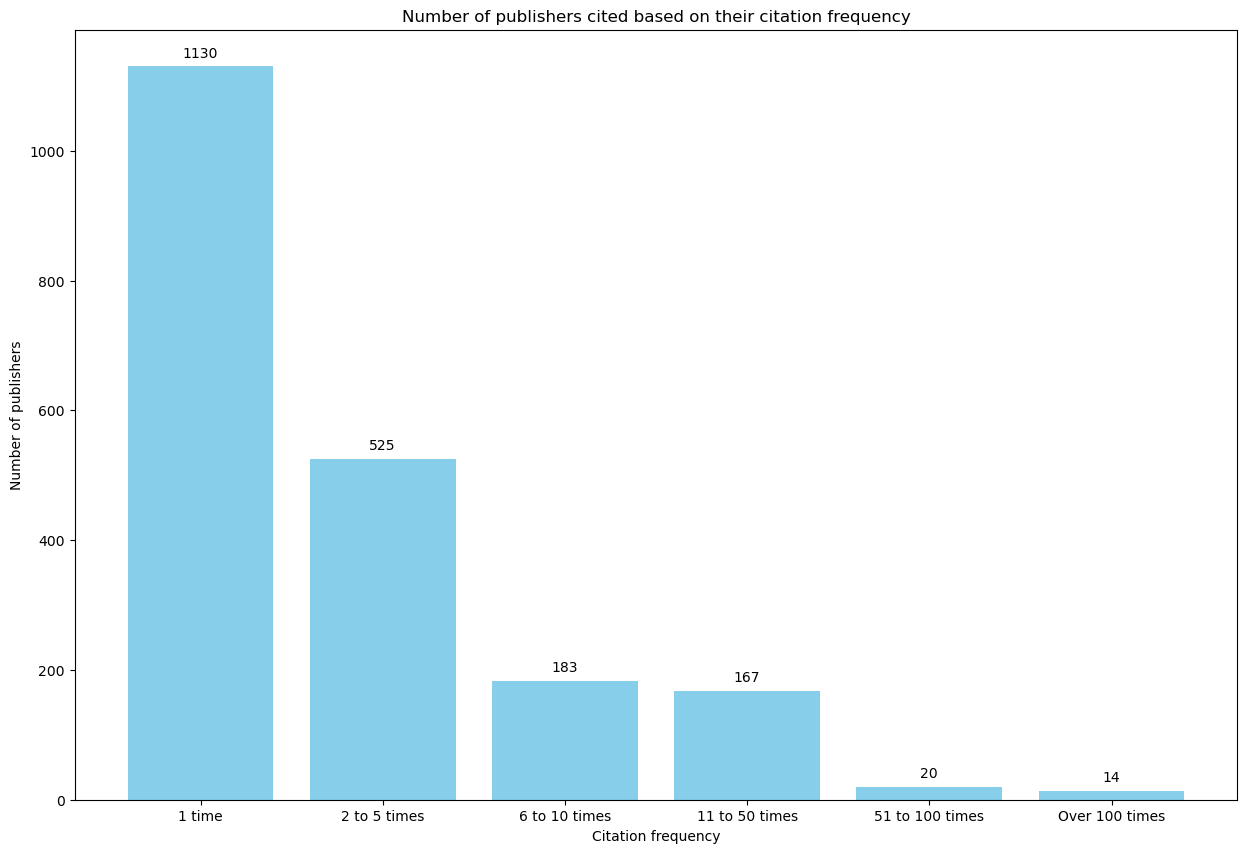

In [29]:
# Let's make an histogram to count the number of times each publisher is cited
# Define the categories for the histogram
bins = [1, 2, 5, 10, 50, 100, float('inf')]  # bins represent citation frequency intervals
labels = ['1 time', '2 to 5 times', '6 to 10 times', '11 to 50 times', '51 to 100 times', 'Over 100 times']
publisher_counts = df_da["publisher"].value_counts()
# Create a new column with the bin labels
publisher_category = pd.cut(publisher_counts, bins=bins, labels=labels, right=False)

# Count the number of publishers in each category
publisher_counts_per_category = publisher_category.value_counts()

# Define the desired order of categories
desired_order = ['1 time', '2 to 5 times', '6 to 10 times', '11 to 50 times', '51 to 100 times', 'Over 100 times']

# Sort the publisher counts according to the desired order
publisher_counts_per_category = publisher_counts_per_category.reindex(desired_order)

# Plot the total number of publishers belonging to each category 

# Plot the bar graph
plt.figure(figsize=(15,10))
# Create the histogram
plt.bar(range(len(publisher_counts_per_category)), publisher_counts_per_category.values, color='skyblue')

# Add title and axis labels
plt.title('Number of publishers cited based on their citation frequency')
plt.xlabel('Citation frequency')
plt.ylabel('Number of publishers')

# Add custom x-axis labels
plt.xticks(range(len(publisher_counts_per_category)), publisher_counts_per_category.index)

# Display values next to each bar
for index, value in enumerate(publisher_counts_per_category):
    plt.text(index, value+10, str(value), ha='center', va='bottom')

# Show the plot
plt.show()

We see that we don't have that many highly cited publishers, as the most common ones are just the ones that are cited less in the dataset.

<span style="color:red; font-family:Papyrus; font-size:1.5em;">Authors</span>



In [30]:
# Check for duplicates in a specific column using value_counts
authors_counts = df["authors"].value_counts()
# Display values with count greater than 1 (indicating duplicates)
display(authors_counts[authors_counts > 1])

# number of authors 
number_of_authors = df["authors"].nunique()
display("Number of authors :", number_of_authors)

authors
p.g. wodehouse                                            40
rumiko takahashi                                          39
stephen king                                              39
orson scott card                                          35
agatha christie                                           33
                                                          ..
thomas harlan                                              2
f. scott fitzgerald/james l.w. west iii                    2
marcia angell                                              2
rob kidd/walt disney company                               2
geraldine mccaughrean/victor g. ambrus/herman melville     2
Name: count, Length: 1359, dtype: int64

'Number of authors :'

6643

In [31]:
#top 10 authors that have highest ratings
auth = df_da[["authors", "ratings_count", "average_rating"]].groupby(["authors"]).agg({"ratings_count" : "sum", "average_rating": "mean"}).reset_index().sort_values("average_rating", ascending = False)
auth["Rating_Category"] = auth.apply(rate2, axis=1)
auth = auth.head(30)
fig2 = px.bar(auth, y='ratings_count', x='authors', color="Rating_Category", text_auto='.2s', title="Rating Count Vs. top 30 rated Authors")
fig2.update_xaxes(nticks=38)
fig2.update_traces(textfont_size=12, textangle=0, textposition="outside", marker_color='green', cliponaxis=False)
fig2.update_layout(xaxis={'categoryorder':'total descending'})
fig2.show()

We remark the same phenomenon, the authors rated the max (5.0) received the lowest rating counts, showing this reverse relationship, but authors who received high to highest average ratings also received the largest rating counts.

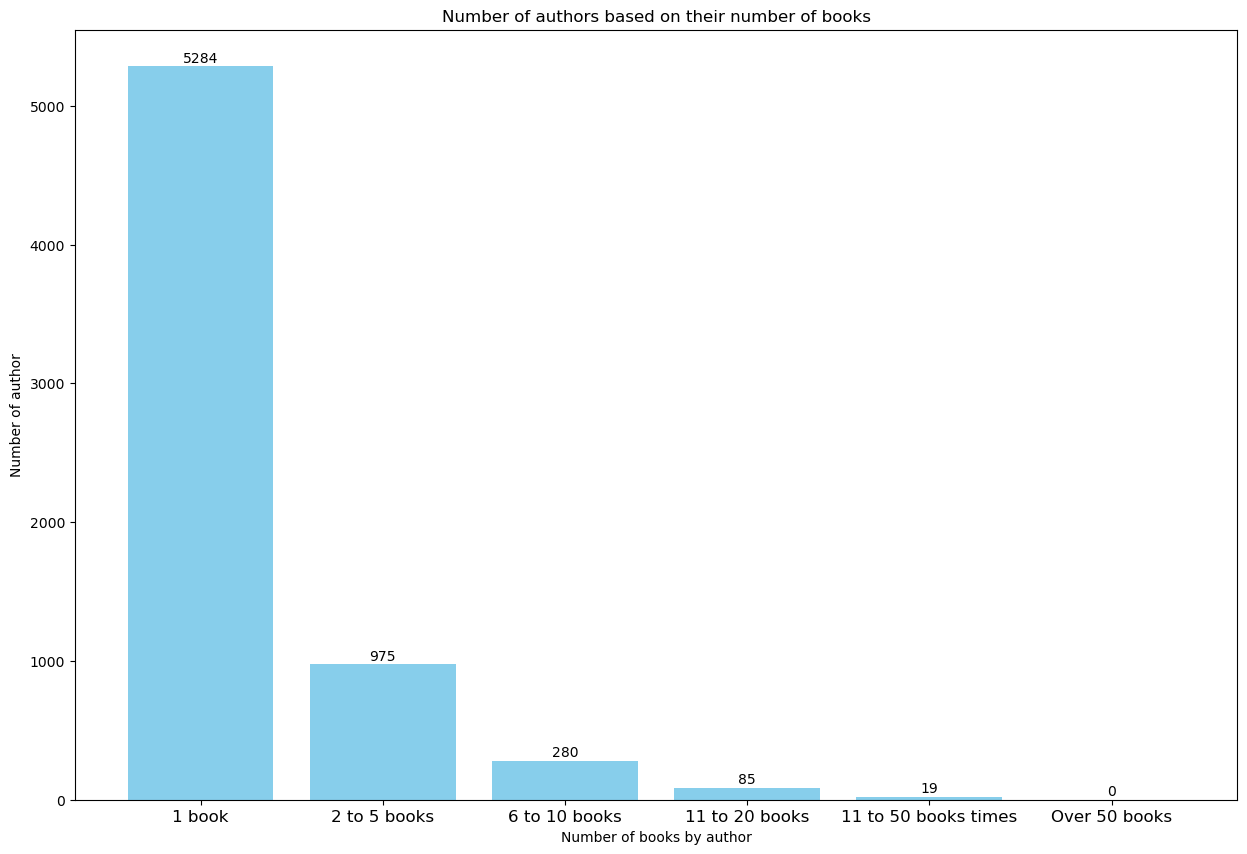

In [32]:
# Let's make an histogram to count the number of books by author
# Define the categories for the histogram
bins = [1, 2, 5, 10, 20, 50, float('inf')]  # bins represent citation frequency intervals
labels = ['1 book', '2 to 5 books', '6 to 10 books', '11 to 20 books', '11 to 50 books times', 'Over 50 books']
author_number_books = df_da['authors'].value_counts()
# Create a new column with the bin labels
author_category = pd.cut(author_number_books, bins=bins, labels=labels, right=False)

# Count the number of authors in each category
author_counts_per_category = author_category.value_counts()

# Define the desired order of categories
desired_order = ['1 book', '2 to 5 books', '6 to 10 books', '11 to 20 books', '11 to 50 books times', 'Over 50 books']

# Sort the author counts according to the desired order
author_counts_per_category = author_counts_per_category.reindex(desired_order)

# Plot the total number of authors belonging to each category 

# Plot the bar graph
plt.figure(figsize=(15,10))
# Create the histogram
plt.bar(range(len(author_counts_per_category)), author_counts_per_category.values, color='skyblue')

# Add title and axis labels
plt.title('Number of authors based on their number of books')
plt.xlabel('Number of books by author')
plt.ylabel('Number of author')

# Add custom x-axis labels with a specific font size
plt.xticks(range(len(author_counts_per_category)), author_counts_per_category.index, fontsize=12)

# Display values next to each bar
for index, value in enumerate(author_counts_per_category):
    plt.text(index, value+10, str(value), ha='center', va='bottom')

# Show the plot
plt.show()

We remark that authors who wrote single books are the most common.

<span style="color:red; font-family:Papyrus; font-size:1.5em;">num_page</span>


In [33]:
# use describe to get a general information of the num_pages
df_da.num_pages.describe()

count    11115.000000
mean       336.458030
std        241.052617
min          0.000000
25%        192.000000
50%        299.000000
75%        416.000000
max       6576.000000
Name: num_pages, dtype: float64

In [34]:
fig4 = px.histogram(df_da, x="num_pages", title="Distribution of books according to their number of pages")
fig4.update_xaxes(nticks=70)
fig4.update_traces(textfont_size=12, textangle=0, textposition="outside", marker_color='green', cliponaxis=False)
fig4.update_layout(bargap=0.2)
fig4.show()

We can see that most book have page number raning from 100 to 450.

In [35]:
# check how many books have very high, very low and zero number of pages
print("number of books with pages more than 5000 is: ", len(df_da.query('num_pages >= 5000')))
print("number of books with pages between 2000 and 5000 is: ", len(df_da.query('2000 <= num_pages < 5000')))
print("number of books with pages between 1000 and 2000 is: ", len(df_da.query('1000 <= num_pages < 2000')))
print("number of books with pages between 5 and 10 is: ", len(df_da.query('5 <= num_pages < 10')))
print("number of books with pages less that 5 is: ", len(df_da.query('num_pages <= 5')))
print("number of books with zero pages are: ", len(df_da.query('num_pages == 0')))

number of books with pages more than 5000 is:  1
number of books with pages between 2000 and 5000 is:  11
number of books with pages between 1000 and 2000 is:  205
number of books with pages between 5 and 10 is:  63
number of books with pages less that 5 is:  146
number of books with zero pages are:  74


Link between average rating and number of pages

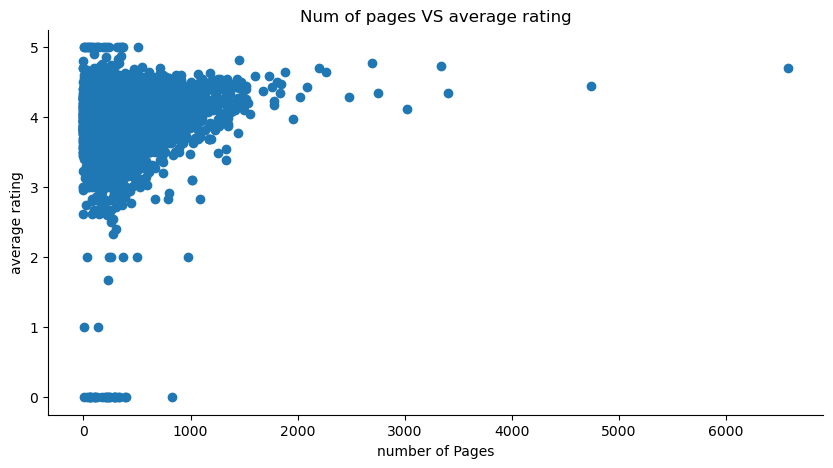

In [36]:
plt.figure(figsize=(10,5))
plt.scatter(df_da['num_pages'],df_da['average_rating'])
plt.title("Num of pages VS average rating")
plt.xlabel("number of Pages")
plt.ylabel("average rating")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

Let's look closely

Text(0.5, 1.02, 'Relationship between Average Rating and Number of Pages')

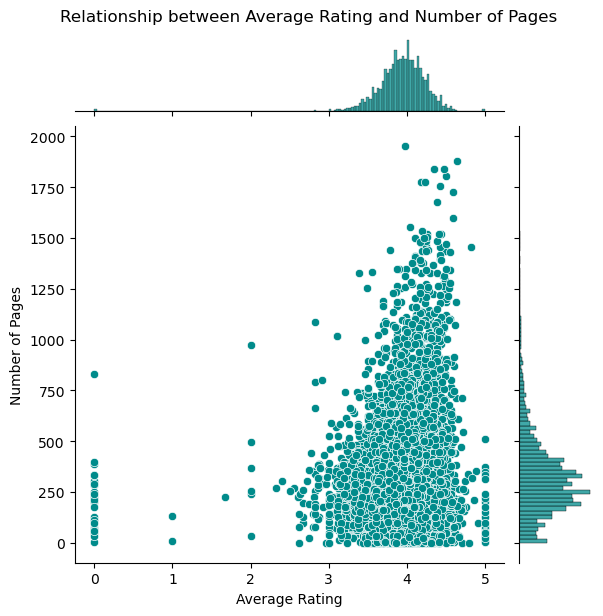

In [37]:
trial = df_da[(df_da['num_pages']<2000)]
ax = sns.jointplot(x="average_rating", y="num_pages", data = trial, color = 'darkcyan')
ax.set_axis_labels("Average Rating", "Number of Pages")
ax.fig.suptitle("Relationship between Average Rating and Number of Pages", y=1.02)

It's very difficult to remark something as obvious, but we can see a tendency in the form of as the number of pages increase up to 1500 we see the average rating increases.

In [38]:
print('The correlation between average_rating and num_pages is',df['average_rating'].corr(df['num_pages'], method="spearman"))

The correlation between average_rating and num_pages is 0.11072834894194816


Link between text review counts, rating counts and number of pages

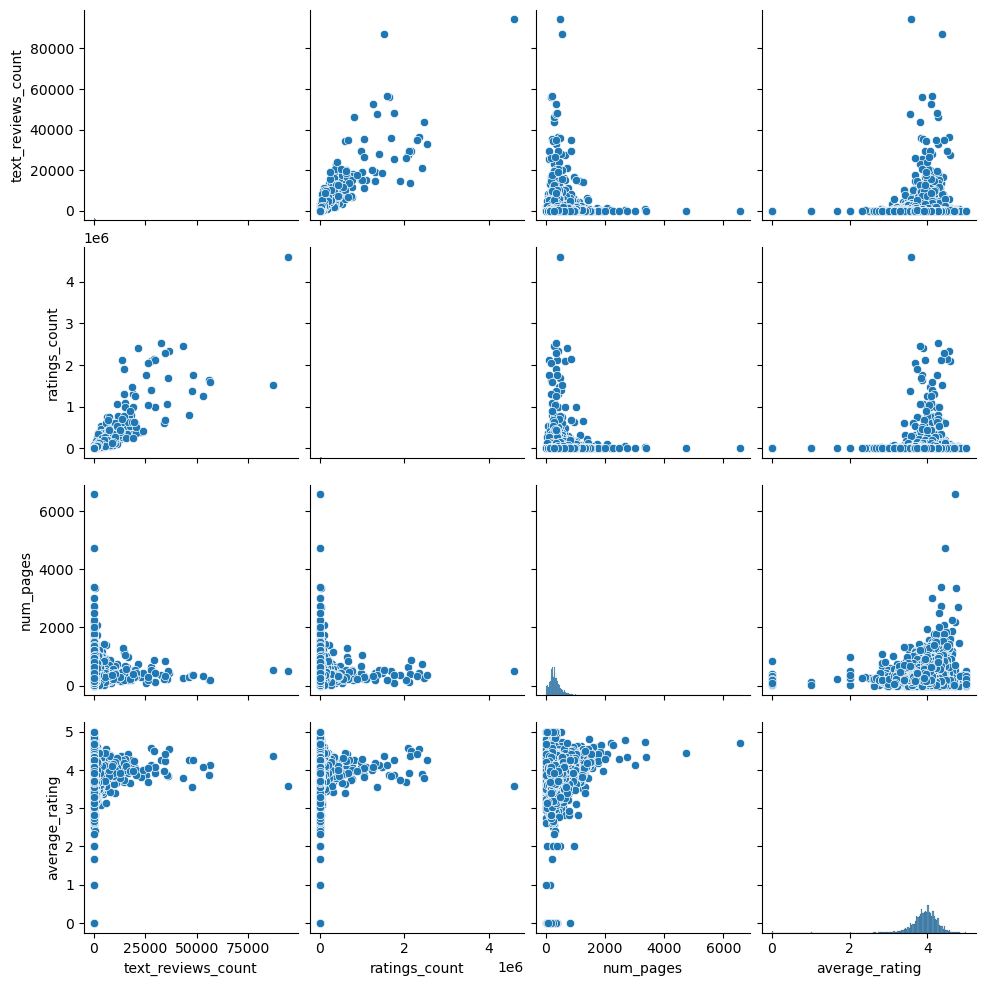

In [39]:
pairplot_vars = ['text_reviews_count', 'ratings_count', 'num_pages', 'average_rating']
sns.pairplot(df_da, vars=pairplot_vars) # we don't need , hue="average_rating"
plt.show()

Books with Zero or few pages

In [40]:
df_da.loc[df['num_pages']==0,:] #no few, just zero
few_pages=df.loc[df['num_pages']<20,:] 
few_pages

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,...,first_author,num_contributors,size_of_publisher,size_of_author,book_count,is_serie,has_edition,book_age,category,genre_category
10,16,the hitchhikers guide to the galaxy hitchhiker...,douglas adams/stephen fry,4.22,0739322206,9780739322208,eng,6,1266,253,...,douglas adams,2,3,2,4,1,1,0,audio,juvenile fiction
40,68,the known world,edward p. jones/kevin r. free,3.83,006076273x,9780060762735,en-us,14,55,12,...,edward p jones,2,1,1,4,0,1,1,audio,fiction
215,524,lord of the flies,william golding,3.68,0307281701,9780307281708,eng,6,408,96,...,william golding,1,1,1,3,0,1,0,audio,fiction
306,955,the 5 love languages the 5 love languages journal,gary chapman,4.70,0802415318,9780802415318,eng,0,22,4,...,gary chapman,1,1,1,1,0,0,1,paperback,family & relationships
309,966,angeles demonios,dan brown/raúl amundaray,3.89,0972859896,9780972859899,spa,18,65,7,...,dan brown,2,1,2,1,0,1,1,audio,fiction
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10961,44979,howards end,e.m. forster/nadia may,3.96,0786168471,9780786168477,eng,9,32,16,...,em forster,2,1,2,4,0,1,0,audio,juvenile fiction
10996,45161,the roald dahl audio collection,roald dahl,4.41,0061214965,9780061214967,en-us,4,199,36,...,roald dahl,1,1,3,1,0,1,0,audio,fiction
11068,45465,artemis fowl artemis fowl 1,eoin colfer/nathaniel parker,3.84,1400085918,9781400085910,eng,6,55,14,...,eoin colfer,2,1,2,3,1,1,1,audio,juvenile fiction
11069,45472,treasury of american tall tales volume 1 davy ...,david bromberg/jay ungar/molly mason/garrison ...,3.86,0739336509,9780739336502,eng,0,36,9,...,david bromberg,11,1,1,1,0,0,1,audio,fiction


There seems to be a lot of books with very few pages. We will look at these in more details below. 

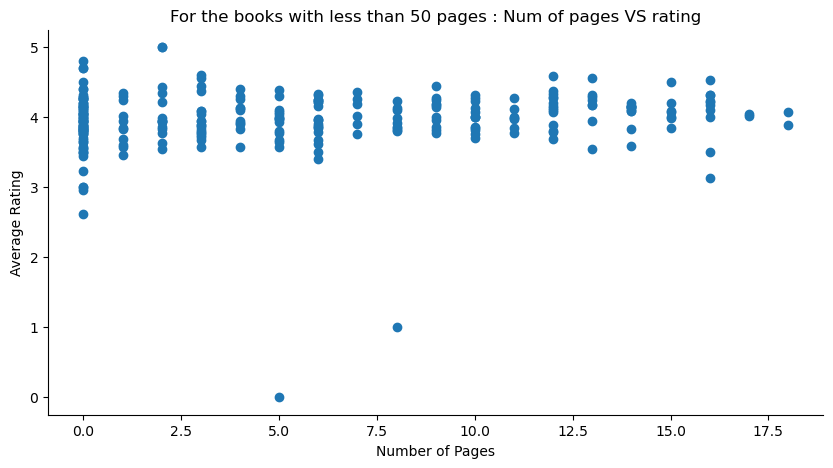

In [41]:
plt.figure(figsize=(10,5))
plt.scatter(few_pages['num_pages'],few_pages['average_rating'])
plt.title("For the books with less than 50 pages : Num of pages VS rating")
plt.xlabel("Number of Pages")
plt.ylabel("Average Rating")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

In [42]:
few_pages.sample(5)

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,...,first_author,num_contributors,size_of_publisher,size_of_author,book_count,is_serie,has_edition,book_age,category,genre_category
10456,42606,as you like it,william shakespeare/arkangel cast/victoria ham...,3.83,1932219048,9781932219043,en-us,2,28,6,...,william shakespeare,5,1,3,3,0,1,0,audio,man-woman relationships
4560,16414,joy in the morning,p.g. wodehouse/chris miller,4.34,0563557354,9780563557357,eng,2,49,7,...,pg wodehouse,2,2,3,1,0,1,0,audio,fiction
10449,42579,water water everywhere a splash giggle bath bo...,julie aigner-clark/nadeem zaidi,3.71,0786819111,9780786819119,eng,10,79,10,...,julie aignerclark,2,2,1,1,0,0,1,other,juvenile fiction
3871,13842,the botany of desire a plantseye view of the w...,michael pollan/scott brick,4.06,1596590939,9781596590939,eng,0,117,36,...,michael pollan,2,1,1,2,0,1,1,audio,biography & autobiography
1959,7037,in the company of cheerful ladies no 1 ladies ...,alexander mccall smith/lisette lecat,4.08,1419311743,9781419311741,eng,10,133,23,...,alexander mccall smith,2,1,2,3,1,1,1,audio,fiction


By looking at the first few rows, some of these books are very well known books, which should have more than 20 pages. One possible explanation: *Audio collection*

The data analysis showed that there is Audiobook on the file, so the number of pages is irrelevant for Audio books.

In [43]:
df_da.loc[df['authors']=='NOT A BOOK',:]
df_da.loc[(df['title'].str.contains('Audio', case=False)),:] 

,title,authors,average_rating,num_pages,ratings_count,text_reviews_count,genre_category,publication_date,publisher,language_code,...,coordinates,num_contributors,size_of_publisher,is_serie,size_of_author,book_count,has_edition,book_age,clean_title,Avg_Rating_Category
1325,the ernest hemingway audio collection,ernest hemingway/charlton heston,4.30,4,43,6,biography & autobiography,5/8/2001,caedmon,en-us,...,"(37.09024, -95.712891)",2,1,0,2,1,0,1,the ernest hemingway audio collection,High
1842,the patricia cornwell cd audio treasury all th...,patricia cornwell/kate burton,4.16,0,202,1,juvenile fiction,7/26/2005,harperaudio,eng,...,"(55.378051, -3.435973)",2,1,1,2,1,1,1,the patricia cornwell cd audio treasury all th...,High
5938,the neil gaiman audio collection,neil gaiman,4.24,1,1666,208,juvenile fiction,8/31/2004,harperchildrens audio,eng,...,"(55.378051, -3.435973)",1,1,0,2,1,0,1,the neil gaiman audio collection,High
6344,the edgar allan poe audio collection,edgar allan poe,4.39,5,289,64,biography & autobiography,10/1/2000,harper audio,eng,...,"(37.09024, -95.712891)",1,1,0,2,1,0,0,the edgar allan poe audio collection,High
7436,judge dredd audio cassette,neal barrett jr./martha banta,2.96,0,6,0,juvenile fiction,7/1/1995,random house audio,eng,...,"(55.378051, -3.435973)",2,3,0,1,1,0,1,judge dredd audio cassette,Lowest
10996,the roald dahl audio collection,roald dahl,4.41,4,199,36,fiction,2/20/2007,harperfestival,en-us,...,"(55.378051, -3.435973)",1,1,0,3,1,1,0,the roald dahl audio collection,High


<span style="color:red; font-family:Papyrus; font-size:1.5em;">Languages</span>

In [44]:
# number of languages code
number_of_languages = df["language_code"].nunique()
print("Number of language code :", number_of_languages)

Number of language code : 27


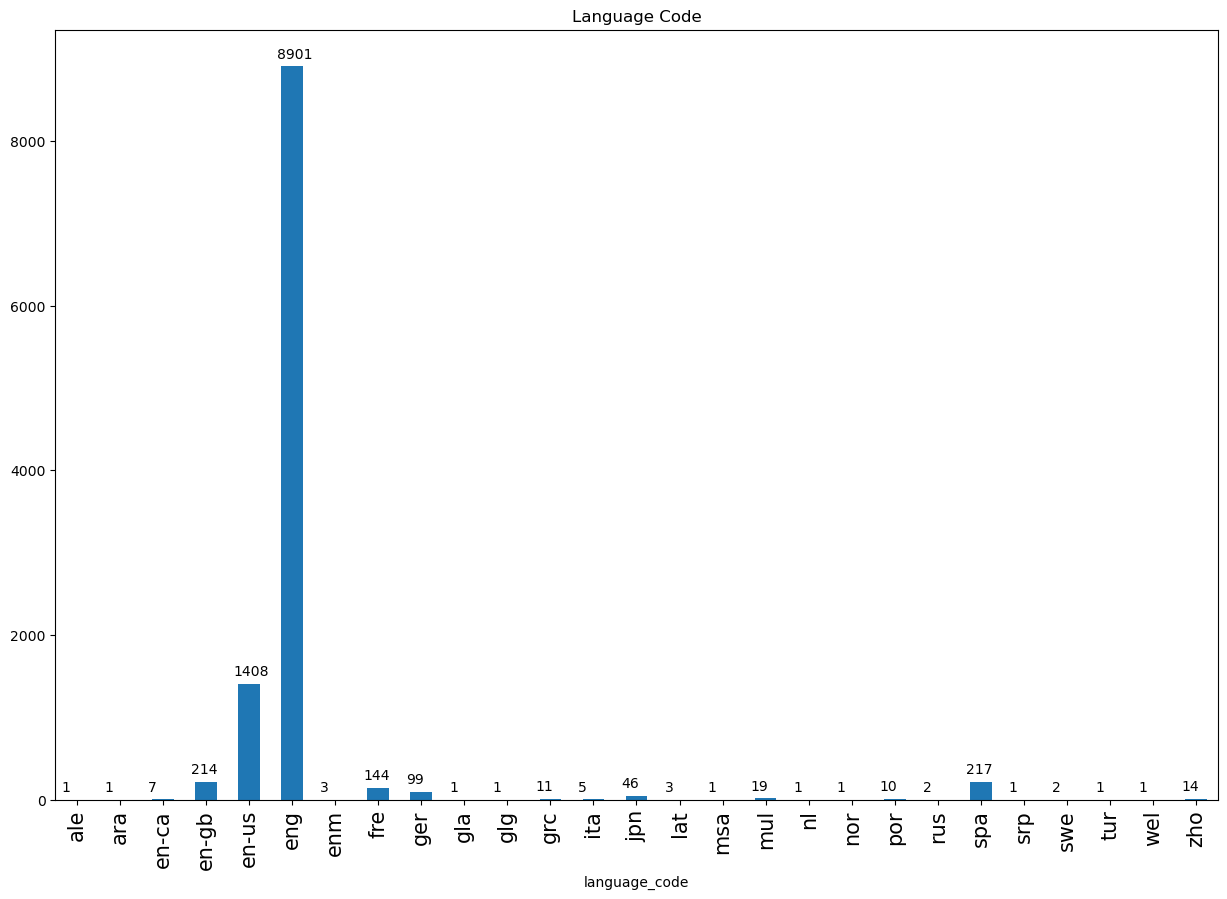

In [45]:
# Check the different type of languages
plt.figure(figsize=(15,10))
ax = df.groupby('language_code')['title'].count().plot.bar()
plt.title('Language Code')
plt.xticks(fontsize = 15)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x()-0.1, p.get_height()+100))

In [46]:
num_books_english = len(df.loc[df['language_code'].str.contains('en', case=False)])
print("Number of books in english :", num_books_english, "out of", len(df))
print(round(num_books_english / len(df) * 100,2), "% of the books are in english")

Number of books in english : 10533 out of 11115
94.76 % of the books are in english


This language_code is nearly constant as it is 95% english language

In [47]:
fig1 = px.histogram(df_da, x="average_rating", color="language_code", barmode = "group", title="Average rating vs. Language")
fig1.update_xaxes(nticks=15)
fig1.show()

Most high average ratings are coming from english language books followed by spanish and german books.